# **DOA Estimation Simulation**

This notebook demonstrates with multiple sources, snapshot averaging, and robust peak detection.

## **1. Import Libraries**

In [71]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

plt.style.use('seaborn-v0_8')

## **2. Signal Model**

The received signal at an array of $M$ sensors with $K$ sources is:

$$
\mathbf{X}(t) = \mathbf{A}(\theta) \mathbf{S}(t) + \mathbf{N}(t)
$$

Where:
- $\mathbf{X}(t) \in \mathbb{C}^{M \times N}$ — received signal matrix (M sensors, N snapshots)
- $\mathbf{A}(\theta) \in \mathbb{C}^{M \times K}$ — steering matrix

$$
\mathbf{A}(\theta) =
\begin{bmatrix}
1 & 1 & \dots & 1 \\
e^{-j 2 \pi d \sin\theta_1} & e^{-j 2 \pi d \sin\theta_2} & \dots & e^{-j 2 \pi d \sin\theta_K} \\
\vdots & \vdots & \ddots & \vdots \\
e^{-j 2 \pi d (M-1) \sin\theta_1} & e^{-j 2 \pi d (M-1) \sin\theta_2} & \dots & e^{-j 2 \pi d (M-1) \sin\theta_K}
\end{bmatrix}
$$

- $\mathbf{S}(t) \in \mathbb{C}^{K \times N}$ — source signal matrix  
- $\mathbf{N}(t) \in \mathbb{C}^{M \times N}$ — additive noise

## **3. Parameters**

In [72]:
# Array and signal parameters
M = 16 # Number of sensors
d = 0.5 # Sensor spacing (wavelengths)
angles = np.array([10, 20, 30, 50, 77]) # Source DOAs (degrees)
num_sources = len(angles)

fs = 1000 # Sampling frequency
duration = 1 # Duration (seconds)
t = np.linspace(0, duration, int(fs*duration))  # Time vector

SNR_dB = 5 # Desired SNR at array (dB)

print(f"Number of sensors: {M}, Number of sources: {num_sources}, SNR: {SNR_dB} dB")

Number of sensors: 16, Number of sources: 5, SNR: 5 dB


## **4. Generate Source Signals (Sum of Sinusoids)**

In [73]:
def generate_source_signal(t, freqs_per_source=3, freq_range=(50, 500)):
    freqs = np.random.uniform(freq_range[0], freq_range[1], freqs_per_source)
    signal = np.sum([np.sin(2*np.pi*f*t) for f in freqs], axis=0)
    return signal

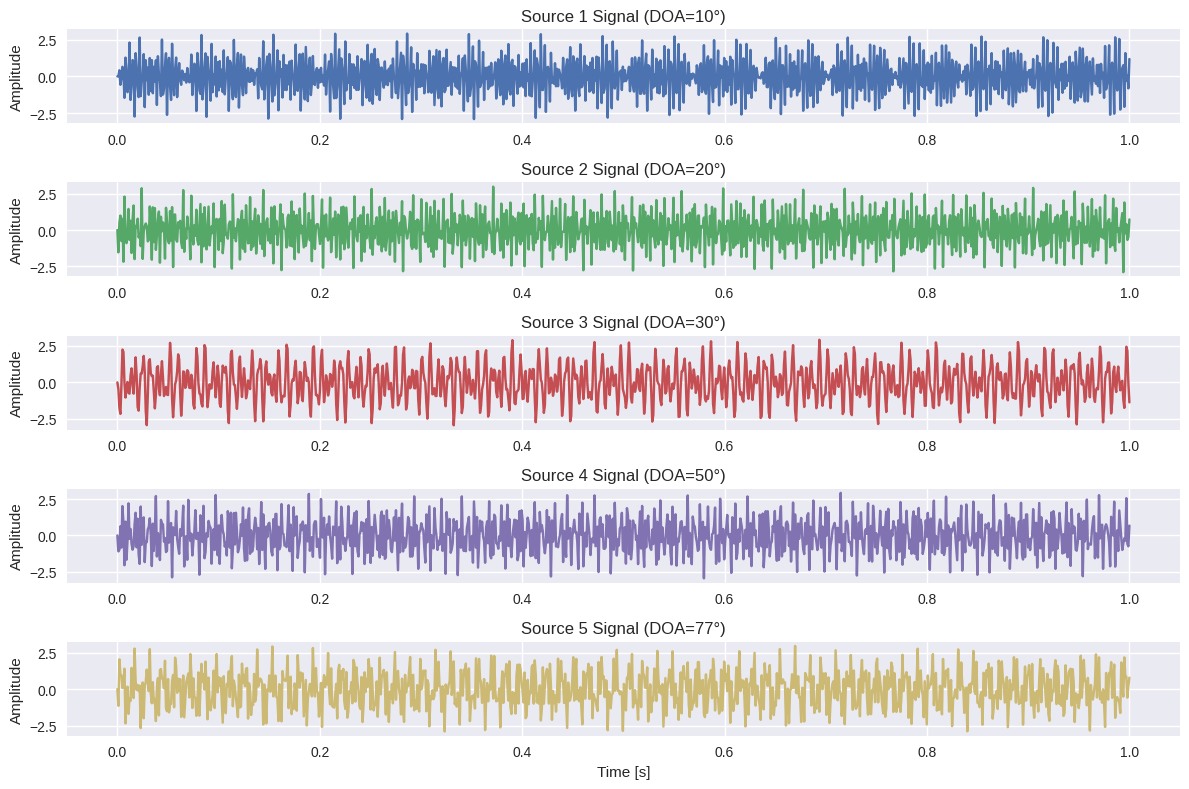

In [74]:
S = np.zeros((num_sources, len(t)))
for i in range(num_sources):
    S[i, :] = generate_source_signal(t, freqs_per_source=3, freq_range=(50, 900))

# Plot source signals
plt.figure(figsize=(12, 8))
for i in range(num_sources):
    plt.subplot(num_sources, 1, i+1)
    plt.plot(t, S[i], color=f'C{i}')
    plt.title(f"Source {i+1} Signal (DOA={angles[i]}°)")
    plt.ylabel("Amplitude")
    plt.grid(True)
plt.xlabel("Time [s]")
plt.tight_layout()
plt.show()

## **5. Steering Matrix and Received Signals**

In [75]:
# Steering matrix
A = np.zeros((M, num_sources), dtype=complex)
for i, angle in enumerate(angles):
    theta = np.deg2rad(angle)
    A[:, i] = np.exp(-1j * 2 * np.pi * d * np.arange(M) * np.sin(theta))

# Additive noise
signal_power = np.mean(np.abs(A @ S)**2)
noise_power = signal_power / 10**(SNR_dB/10)
N = np.sqrt(noise_power/2) * (np.random.randn(M, len(t)) + 1j * np.random.randn(M, len(t)))

# Received signals
X = A @ S + N

# Verify shapes
print("Steering matrix A:", A.shape)
print("Source signals S:", S.shape)
print("Noise N:", N.shape)
print("Received signals X:", X.shape)

Steering matrix A: (16, 5)
Source signals S: (5, 1000)
Noise N: (16, 1000)
Received signals X: (16, 1000)


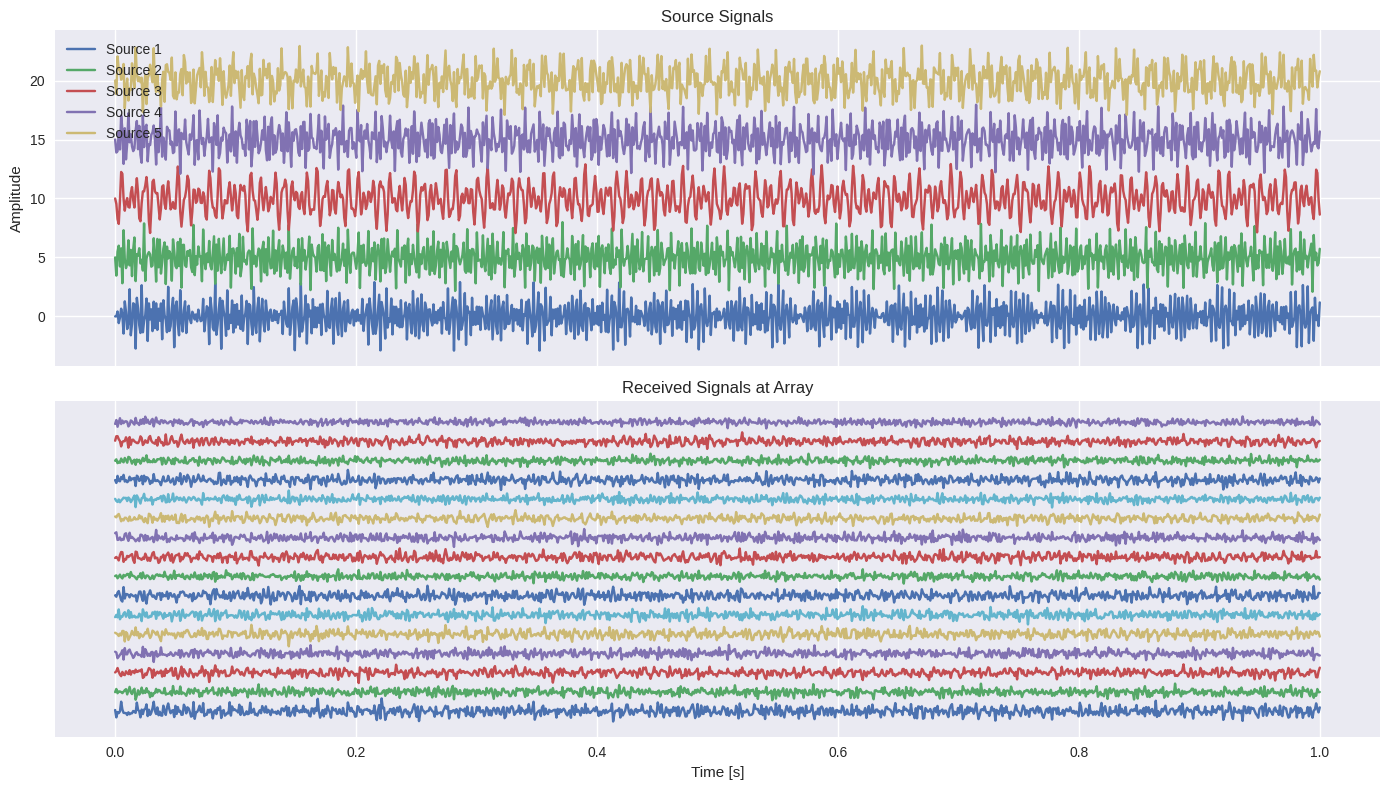

In [76]:
# Plot Received Signals
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Original sources (shifted for clarity)
for i in range(num_sources):
    axs[0].plot(t, S[i] + i*5, label=f"Source {i+1}")
axs[0].set_title("Source Signals")
axs[0].set_ylabel("Amplitude")
axs[0].legend()
axs[0].grid(True)

# Received array signals
offset = 1.5 * np.max(np.abs(X.real))
for m in range(M):
    axs[1].plot(t, X[m].real + m*offset, label=f"Sensor {m+1}")
axs[1].set_title("Received Signals at Array")
axs[1].set_xlabel("Time [s]")
axs[1].set_yticks([])
axs[1].grid(True)

plt.tight_layout()
plt.show()

## **6. Spatial Correlation Matrix**

$$
\mathbf{R}_{xx} = \frac{1}{N} \mathbf{X} \mathbf{X}^H
$$

In [77]:
Rxx = (X @ X.conj().T) / X.shape[1]
Rxx_df = pd.DataFrame(np.abs(Rxx))

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(Rxx_df)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,9.951755,4.877692,0.796140,2.550856,0.865463,0.868978,1.218167,3.138373,2.639914,3.767054,4.893499,2.051985,4.002104,5.560671,3.686637,2.757721
1,4.877692,9.897697,4.884273,0.883937,2.644276,0.999889,1.067743,1.158509,2.793277,2.414615,3.771597,5.192005,2.044578,4.384339,5.695246,3.655972
2,0.796140,4.884273,10.045859,4.961826,0.859551,2.818434,0.813650,1.042988,0.973828,3.104349,2.779415,3.731005,4.959153,1.873772,4.030283,5.868139
3,2.550856,0.883937,4.961826,10.398987,4.879987,1.023600,2.806448,0.968291,0.928990,1.024606,3.144412,2.613486,3.875249,5.095163,1.994867,4.498956
4,0.865463,2.644276,0.859551,4.879987,10.104299,4.719389,0.992913,2.576313,0.975291,0.727820,0.804199,3.218630,2.572982,3.955238,5.008799,1.906376
5,0.868978,0.999889,2.818434,1.023600,4.719389,9.858626,4.739308,0.728656,2.624242,0.663105,0.895970,1.094736,2.891933,2.598842,3.808132,5.171036
6,1.218167,1.067743,0.813650,2.806448,0.992913,4.739308,10.161837,4.738772,1.070172,2.591675,0.934205,0.972005,0.985058,3.019005,2.574815,3.790630
7,3.138373,1.158509,1.042988,0.968291,2.576313,0.728656,4.738772,9.863208,4.859833,0.991736,2.614976,1.109033,1.010480,0.873621,3.006347,2.776950
8,2.639914,2.793277,0.973828,0.928990,0.975291,2.624242,1.070172,4.859833,9.789761,4.736374,0.984109,2.815510,0.981914,0.872062,1.042274,3.135956
9,3.767054,2.414615,3.104349,1.024606,0.727820,0.663105,2.591675,0.991736,4.736374,10.074189,5.009690,1.035459,2.619425,1.068849,0.828126,0.981971


## **7. MUSIC DOA Estimation**

The MUSIC spatial spectrum:

$$
P_{\text{MUSIC}}(\theta) = \frac{1}{\mathbf{a}(\theta)^H \mathbf{E}_n \mathbf{E}_n^H \mathbf{a}(\theta)}
$$

Where:
- $\mathbf{a}(\theta)$ — steering vector for angle $\theta$
- $\mathbf{E}_n$ — noise subspace (eigenvectors of smallest eigenvalues of $\mathbf{R}_{xx}$)

In [78]:
# Function for MUSIC DOA Estimation
def music_doa_estimation(X, num_sources, d=0.5, scan_angles=np.arange(-90, 91, 0.2)):
    M, N = X.shape
    Rxx = (X @ X.conj().T) / N
    eigvals, eigvecs = np.linalg.eigh(Rxx)  # eigh for Hermitian
    idx = eigvals.argsort()[::-1]
    eigvecs = eigvecs[:, idx]
    En = eigvecs[:, num_sources:]  # Noise subspace

    P_music = []
    for angle in scan_angles:
        theta = np.deg2rad(angle)
        a = np.exp(-1j * 2 * np.pi * d * np.arange(M) * np.sin(theta)).reshape(-1,1)
        P = 1 / np.abs(a.conj().T @ En @ En.conj().T @ a)
        P_music.append(P[0,0].real)

    return np.array(scan_angles), np.array(P_music)

# Snapshot-Averaged MUSIC Estimation
def snapshot_averaged_music(X, num_sources, N_snapshots=5, scan_angles=np.arange(-90, 91, 0.5)):
    M, total_samples = X.shape
    P_avg = None
    for n in range(N_snapshots):
        start = n*(total_samples//N_snapshots)
        end = (n+1)*(total_samples//N_snapshots)
        X_snap = X[:, start:end]
        _, P_music = music_doa_estimation(X_snap, num_sources, scan_angles=scan_angles)
        if P_avg is None:
            P_avg = P_music
        else:
            P_avg += P_music
    P_avg /= N_snapshots
    return scan_angles, P_avg

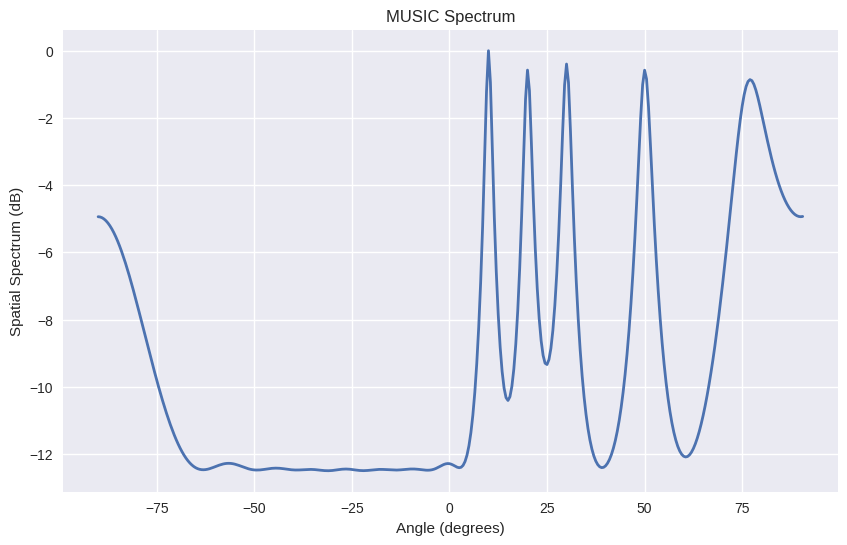

In [79]:
scan_angles, P_music_avg = snapshot_averaged_music(X, num_sources, N_snapshots=50)

# Plot MUSIC Spectrum
plt.figure(figsize=(10,6))
plt.plot(scan_angles, 10*np.log10(P_music_avg/np.max(P_music_avg)), linewidth=2)
plt.title("MUSIC Spectrum")
plt.xlabel("Angle (degrees)")
plt.ylabel("Spatial Spectrum (dB)")
plt.grid(True)
plt.show()

In [80]:
# Find peaks
peaks, _ = find_peaks(P_music_avg, height=np.max(P_music_avg)*0.5, distance=5)
estimated_DOAs = scan_angles[peaks]

# Convert to floats and sort
estimated_DOAs_clean = [float(np.round(angle,2)) for angle in estimated_DOAs]
original_DOAs_clean = [float(angle) for angle in angles]

print("Estimated DOAs (degrees):", sorted(estimated_DOAs_clean))
print("Original DOAs (degrees):", sorted(original_DOAs_clean))

Estimated DOAs (degrees): [10.0, 20.0, 30.0, 50.0, 77.0]
Original DOAs (degrees): [10.0, 20.0, 30.0, 50.0, 77.0]


In [81]:
# Compute RMSE / MSE
rmse = np.sqrt(np.mean((np.sort(estimated_DOAs_clean) - np.sort(original_DOAs_clean))**2))
mse = np.mean((np.sort(estimated_DOAs_clean) - np.sort(original_DOAs_clean))**2)
print(f"RMSE: {rmse:.2f}°, MSE: {mse:.2f}°")

RMSE: 0.00°, MSE: 0.00°


## **8. Capon (MVDR) DOA Estimation**

Capon (MVDR) spatial spectrum:

$$
P_\text{Capon}(\theta) = \frac{1}{\mathbf{a}(\theta)^H \mathbf{R}_{xx}^{-1} \mathbf{a}(\theta)}
$$
where $\mathbf{R}_{xx}$ is the spatial correlation matrix.

In [82]:
# Function for Capon DOA Estimation
def capon_doa_estimation(X, d=0.5, scan_angles=np.arange(-90,91,0.2)):
    M, N = X.shape
    Rxx = (X @ X.conj().T) / N        # Spatial correlation matrix
    Rxx_inv = np.linalg.pinv(Rxx)     # Pseudo-inverse for stability
    P_capon = []
    for angle in scan_angles:
        theta = np.deg2rad(angle)
        a = np.exp(-1j*2*np.pi*d*np.arange(M)*np.sin(theta)).reshape(-1,1)
        P = 1 / np.real(a.conj().T @ Rxx_inv @ a)
        P_capon.append(P[0,0])
    return np.array(scan_angles), np.array(P_capon)

# Snapshot-Averaged Capon
def snapshot_averaged_capon(X, N_snapshots=5, d=0.5, scan_angles=np.arange(-90,91,0.2)):
    M, total_samples = X.shape
    P_avg = None
    for n in range(N_snapshots):
        start = n*(total_samples//N_snapshots)
        end = (n+1)*(total_samples//N_snapshots)
        X_snap = X[:, start:end]
        _, P = capon_doa_estimation(X_snap, d=d, scan_angles=scan_angles)
        if P_avg is None:
            P_avg = P
        else:
            P_avg += P
    P_avg /= N_snapshots
    return scan_angles, P_avg

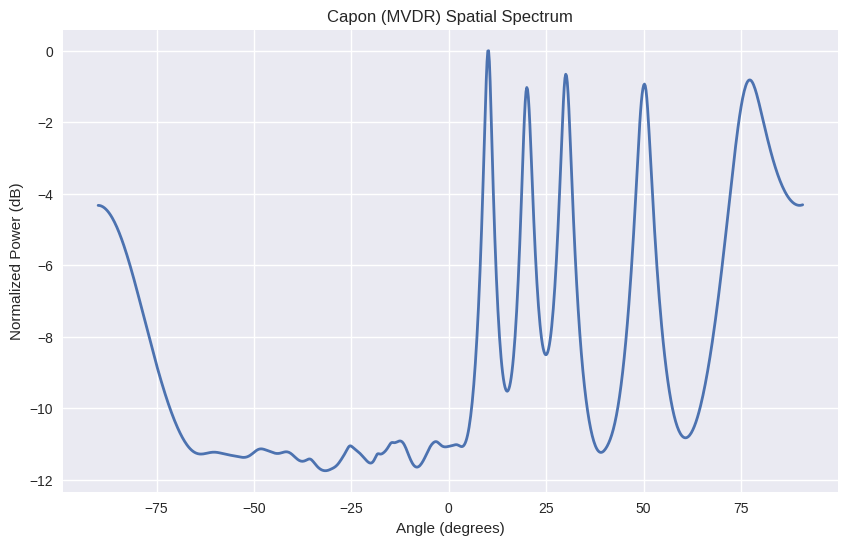

In [83]:
scan_angles, P_capon_avg = snapshot_averaged_capon(X, N_snapshots=50)

# Plot Capon Spectrum
plt.figure(figsize=(10,6))
plt.plot(scan_angles, 10*np.log10(P_capon_avg/np.max(P_capon_avg)), linewidth=2)
plt.title("Capon (MVDR) Spatial Spectrum")
plt.xlabel("Angle (degrees)")
plt.ylabel("Normalized Power (dB)")
plt.grid(True)
plt.show()

In [84]:
# Detect peaks
peaks, _ = find_peaks(P_capon_avg, height=np.max(P_capon_avg)*0.5, distance=5)
estimated_DOAs = scan_angles[peaks]

# Sort and convert to floats
estimated_DOAs_clean = [float(np.round(angle,2)) for angle in estimated_DOAs]
original_DOAs_clean = [float(angle) for angle in angles]

print("Estimated DOAs (degrees):", sorted(estimated_DOAs_clean))
print("Original DOAs (degrees):", sorted(original_DOAs_clean))

Estimated DOAs (degrees): [10.2, 20.0, 30.0, 50.2, 77.2]
Original DOAs (degrees): [10.0, 20.0, 30.0, 50.0, 77.0]


In [85]:
# Compute RMSE / MSE
rmse = np.sqrt(np.mean((np.sort(estimated_DOAs_clean) - np.sort(original_DOAs_clean))**2))
mse = np.mean((np.sort(estimated_DOAs_clean) - np.sort(original_DOAs_clean))**2)
print(f"RMSE: {rmse:.2f}°, MSE: {mse:.2f}°")

RMSE: 0.15°, MSE: 0.02°
